In [1]:
import os
import logging
import shutil
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])

sys.path.append(new_directory)

from Postprocessing import View_results
from Postprocessing import View_results_X

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

results_dir = os.path.sep.join(path_components[:-2])
simulation_name = 'S0'
results_path = os.path.join(results_dir,'.results','TEST_12_04',simulation_name)
main_path = os.path.join(results_dir,'code')
# simulation_name = 'Main'
#results_path = os.path.join(results_dir,'code','results',simulation_name)                        
                         
import shutil
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_test.py'))

print(main_path)
print(results_path)

c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\code
c:\Users\achom\Desktop\Main\Code\Scientific-Computing\Physics-Neural-Networks\PINN\.results\TEST_12_04\S0


In [2]:
from Model.Mesh.Molecule_Mesh import Molecule_Mesh
from Model.PDE_Model import PBE
from NN.NeuralNet import NeuralNet
from NN.PINN import PINN 
from NN.XPINN import XPINN
from Post.Postprocessing import View_results
from Post.Postprocessing import View_results_X

folder_name = 'Main'
folder_path = os.path.join(main_path,'results',folder_name)


from S_test import PDE

sim = PDE()
N_points = {'dx_interior': 0.2,
                'dx_exterior': 0.5,
                'N_border': 6,
                'dx_experimental': 1,
                'N_pq': 10,
                }
for key,value in N_points.items():
    sim.N_points[key] = value

sim.create_simulation()

XPINN_solver = sim.XPINN_solver

In [3]:
Iter = 10000
results_dir_iter = os.path.join(results_path,f'iter_{Iter}')
XPINN_solver.folder_path = folder_path
XPINN_solver.load_NeuralNets(results_dir_iter,['model_1','model_2'])
XPINN_solver.N_iters = XPINN_solver.iter
Post = View_results_X(XPINN_solver, View_results, save=True, directory=folder_path, data=False)


In [4]:
elements = XPINN_solver.mesh.faces
vertices = XPINN_solver.mesh.verts

def u_value(verts,domains=[True,True]):
    verts = tf.constant(verts)
    u_mean = 0.0
    u1 = 0
    u2 = 0
    if domains[0]:
        u1 = XPINN_solver.solver1.model(verts)
    if domains[1]:
        u2 = XPINN_solver.solver2.model(verts)
    u_mean = (u1+u2)/sum(domains)
    return u_mean.numpy()
u_values = u_value(vertices)

def du_value(verts):
    solver1 = XPINN_solver.solver1
    solver2 = XPINN_solver.solver2

    verts = tf.constant(verts)
    X = solver1.mesh.get_X(verts)
    
    N_v = XPINN_solver.mesh.normal
    n_v = solver1.mesh.get_X(N_v)

    du_1 = solver1.PDE.directional_gradient(solver1.mesh,solver1.model,X,n_v)
    du_2 = solver2.PDE.directional_gradient(solver2.mesh,solver2.model,X,n_v)
    du_prom = (du_1*solver1.PDE.epsilon + du_2*solver2.PDE.epsilon)/2

    return du_prom.numpy()

du_values = du_value(vertices)

u_values = u_values.flatten()
du_values = du_values.flatten()

In [5]:
XPINN_solver.PDE.get_dphi_interface(*XPINN_solver.solvers)
XPINN_solver.PDE.get_solvation_energy(*XPINN_solver.solvers)

-10.94214356867497

In [12]:
q_list = XPINN_solver.PDE.q_list
n = len(q_list)
qs = np.zeros(n)
x_qs = np.zeros((n,3))
for i,q in enumerate(q_list):
    qs[i] = q.q
    x_qs[i,:] = q.x_q

In [15]:
import bempp.api

grid = bempp.api.Grid(vertices.transpose(), elements.transpose())

space = bempp.api.function_space(grid, "P", 1)
dirichl_space = space
neumann_space = space

slp_q = bempp.api.operators.potential.laplace.single_layer(neumann_space, x_qs.transpose())
dlp_q = bempp.api.operators.potential.laplace.double_layer(dirichl_space, x_qs.transpose())

phi = bempp.api.GridFunction(space, coefficients=u_values)
dphi = bempp.api.GridFunction(space, coefficients=du_values)

In [16]:
phi_q = slp_q * dphi - dlp_q * phi

G_solv = 2 * np.pi * 332.064 * np.sum(qs * phi_q).real
G_solv

-10.94214356867497

In [104]:
import plotly.graph_objects as go
import numpy as np

def save_mesh_html(vertices, elements, values, filename='mesh_plot.html'):
    fig = go.Figure()

    fig.add_trace(go.Mesh3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
                           i=elements[:, 0], j=elements[:, 1], k=elements[:, 2],
                           intensity=values, colorscale='RdBu_r'))

    fig.update_layout(scene=dict(aspectmode='data'))

    fig.write_html(os.path.join('Plots_results',filename))

save_mesh_html(vertices, elements, values, filename='u_prom.html')
save_mesh_html(vertices, elements, values, filename='du_prom.html')
save_mesh_html(vertices, elements, u_value(vertices, domains=[True,False]), filename='u_1.html')
save_mesh_html(vertices, elements, u_value(vertices, domains=[False,True]), filename='u_2.html')


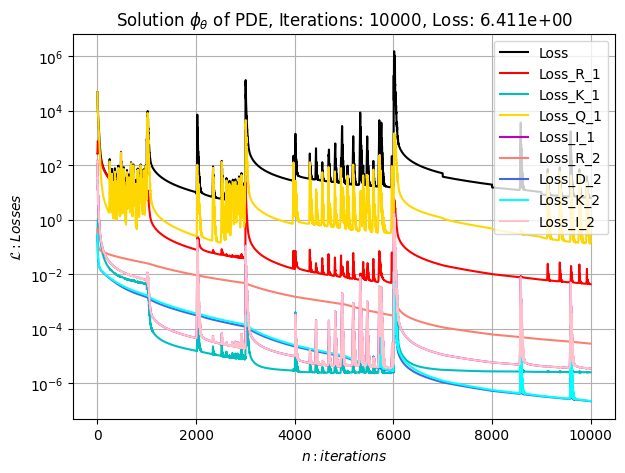

In [105]:
Post.plot_loss_history()

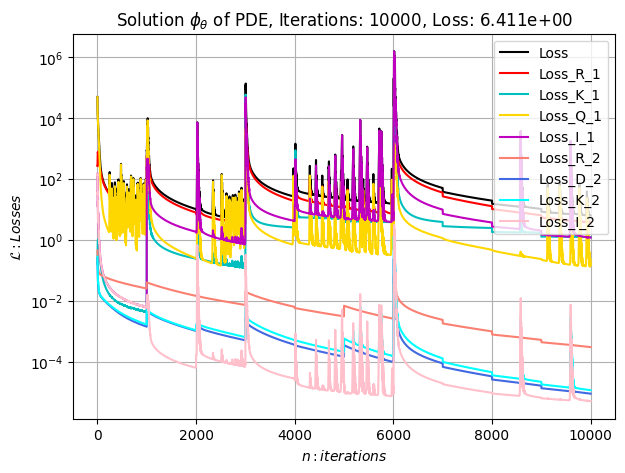

In [106]:
Post.plot_loss_history(plot_w=True)


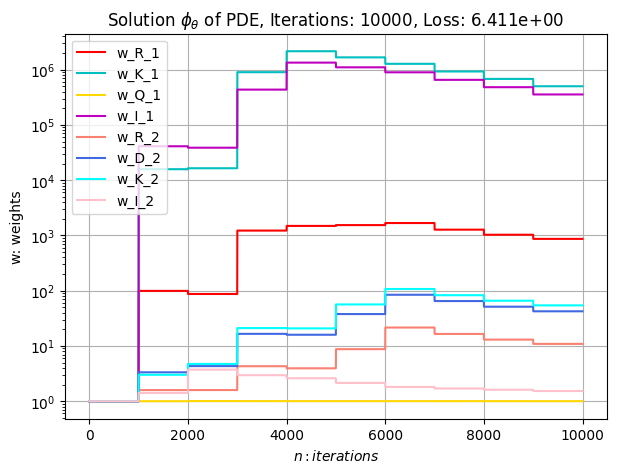

In [107]:
Post.plot_weights_history()